# Matter-Antimatter Asymmetry of B+-  ->  Kpipi using LHCb (2011) data         

## 3rd Year Labs

### Anar Badrakh

1. Selection cuts
2. Plotting Data
3. Fitting
4. Dalitz plots


In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.cm as colormap
from scipy.optimize import curve_fit 
import copy
import scipy
import scipy.integrate

In [2]:
path = '../shared/' # '../' 
events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
events_down = uproot.open(path+'B2HHH_MagnetDown.root')
events_up = uproot.open(path+'B2HHH_MagnetUp.root')

## 1. Selection Cuts

Make cuts to select decays where it is a B meson going into a K+-, pi+-, and pi-+.

Identify which particle is the Kaon.

Cut out unwanted resonances.

In [3]:
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

mK = 493.677
mpi = 139.570
mMu = 105.7
Kcut = 0.85
Pcut = 0.6
mB = 5279.29
mass_cut = 1000
mD = 1864.83 #1860.83
D_cut = 30 # resonance width
mJpsi = 3096.9
Jpsi_cut = 20

k1_counter = 0
k2_counter = 0
k3_counter = 0
Nplus = 0 
Nmin = 0

event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
# Set to -1 to run over all events. 
MAX_EVENTS = -1

pT = [] #tranverse momentum
pX = []
pY = []
pZ = []
m_KPP = [] # invariant masses
m_KP = []
m_PP = []
m_MM = []
m_Bplus  = [] # recontructed B+ mass
m_Bminus = []
Bc = [] #  B charge
Bcc = []

# Use only one set!
#trees = [events_sim['PhaseSpaceTree']]                       
#trees = [events_down[b'DecayTree']]                          
#trees = [events_up['DecayTree']]                             
trees = [events_down[b'DecayTree'],events_up['DecayTree']]   

Input data variables:
[b'B_FlightDistance', b'B_VertexChi2', b'H1_PX', b'H1_PY', b'H1_PZ', b'H1_ProbK', b'H1_ProbPi', b'H1_Charge', b'H1_IPChi2', b'H1_isMuon', b'H2_PX', b'H2_PY', b'H2_PZ', b'H2_ProbK', b'H2_ProbPi', b'H2_Charge', b'H2_IPChi2', b'H2_isMuon', b'H3_PX', b'H3_PY', b'H3_PZ', b'H3_ProbK', b'H3_ProbPi', b'H3_Charge', b'H3_IPChi2', b'H3_isMuon']


In [4]:
# This loop goes over the trees to be analysed
for tree in trees:
    # uproot stores data in chunks so we must loop through them here
    for data in tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon']):
        
        pT_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
        pT_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
        pT_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)
        e_K1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2+mK**2)
        e_K2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2+mK**2)
        e_K3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2+mK**2)
        e_pi1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2+mpi**2)
        e_pi2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2+mpi**2)
        e_pi3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2+mpi**2)
        e_mu1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2+mMu**2)
        e_mu2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2+mMu**2)
        e_mu3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2+mMu**2)    
        
        p12sq = (data[b'H1_PX']+data[b'H2_PX'])**2 + (data[b'H1_PY']+data[b'H2_PY'])**2 + (data[b'H1_PZ']+data[b'H2_PZ'])**2
        p23sq = (data[b'H2_PX']+data[b'H3_PX'])**2 + (data[b'H2_PY']+data[b'H3_PY'])**2 + (data[b'H2_PZ']+data[b'H3_PZ'])**2
        p13sq = (data[b'H1_PX']+data[b'H3_PX'])**2 + (data[b'H1_PY']+data[b'H3_PY'])**2 + (data[b'H1_PZ']+data[b'H3_PZ'])**2


        psq = (data[b'H1_PX']+data[b'H2_PX']+data[b'H3_PX'])**2 \
            + (data[b'H1_PY']+data[b'H2_PY']+data[b'H3_PY'])**2 \
            + (data[b'H1_PZ']+data[b'H2_PZ']+data[b'H3_PZ'])**2

        m_KKKinv = np.sqrt((e_K1+e_K2+e_K3)**2 - psq)
        m_KPPinv = np.sqrt((e_K1+e_pi2+e_pi3)**2 - psq)
        m_PKPinv = np.sqrt((e_pi1+e_K2+e_pi3)**2 - psq)
        m_PPKinv = np.sqrt((e_pi1+e_pi2+e_K3)**2 - psq)
        
        m12PPsq = np.sqrt((e_pi1+e_pi2)**2 - p12sq)
        m23PPsq = np.sqrt((e_pi3+e_pi2)**2 - p23sq)
        m13PPsq = np.sqrt((e_pi1+e_pi3)**2 - p13sq)
        m12KKsq = np.sqrt((e_K1+e_K2)**2 - p12sq)
        m23KKsq = np.sqrt((e_K3+e_K2)**2 - p23sq)
        m13KKsq = np.sqrt((e_K1+e_K3)**2 - p13sq)
        m12KPsq = np.sqrt((e_K1+e_pi2)**2 - p12sq)
        m23KPsq = np.sqrt((e_K3+e_pi2)**2 - p23sq)
        m13KPsq = np.sqrt((e_K1+e_pi3)**2 - p13sq)
        m12PKsq = np.sqrt((e_pi1+e_K2)**2 - p12sq)
        m23PKsq = np.sqrt((e_pi3+e_K2)**2 - p23sq)
        m13PKsq = np.sqrt((e_pi1+e_K3)**2 - p13sq)
        m12MMsq = np.sqrt((e_mu1+e_mu2)**2 - p12sq)
        m23MMsq = np.sqrt((e_mu3+e_mu2)**2 - p23sq)
        m13MMsq = np.sqrt((e_mu1+e_mu3)**2 - p13sq)

        B_charge = data[b'H1_Charge'] + data[b'H2_Charge'] + data[b'H3_Charge']
      

        # This loop will go over individual events
        for i in range(0,len(data[b'H1_PZ'])):
            event_counter += 1
            if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
            if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
            # Adding values for all three hadrons to the same variable here            
            if data[b'H1_isMuon'][i] or data[b'H2_isMuon'][i] or data[b'H3_isMuon'][i]: 
                continue # remove 3 muon decays
            if np.abs(B_charge[i]) != 1 : 
                continue # remove decays that don't add up to B+- charge
                
                # checks for the instance where particle 1 is the kaon
            if ((data[b'H2_Charge'][i] + data[b'H3_Charge'][i] == 0)
                and (data[b'H1_ProbK'][i] > data[b'H2_ProbK'][i])      
                and (data[b'H1_ProbK'][i] > data[b'H3_ProbK'][i])
                and (data[b'H1_ProbK'][i] > Kcut) 
                and (data[b'H2_ProbPi'][i] > Pcut) 
                and (data[b'H3_ProbPi'][i] > Pcut)):
                    
                    if np.abs(m_KPPinv[i]-mB) < (mass_cut):
                        if (data[b'H1_Charge'][i]) == (data[b'H3_Charge'][i]): 
                            if np.abs(m23PPsq[i] - mJpsi) > Jpsi_cut: # cutting out unwanted resonances
                                if np.abs(m12KPsq[i] - mD) > D_cut :
                                    m_KPP.append(m_KPPinv[i])
                                    Bc.append(B_charge[i])

                                    k1_counter += 1
                                    m_PP.append(m23PPsq[i])
                                    m_MM.append(m23MMsq[i])
                                    m_KP.append(m12KPsq[i])
                                    Bcc.append(B_charge[i])
                                    if B_charge[i] == 1:
                                        m_Bplus.append(m_KPPinv[i])
                                        Nplus += 1
                                    else:
                                        Nmin += 1
                                        m_Bminus.append(m_KPPinv[i])
                                    
                        else: 
                            if np.abs(m23PPsq[i] - mJpsi) > Jpsi_cut:                                
                                if np.abs(m13KPsq[i] - mD) > D_cut :
                                    m_KPP.append(m_KPPinv[i])
                                    Bc.append(B_charge[i])

                                    k1_counter += 1
                                    m_PP.append(m23PPsq[i])
                                    m_MM.append(m23MMsq[i])
                                    m_KP.append(m13KPsq[i])
                                    Bcc.append(B_charge[i])
                                    if B_charge[i] == 1:
                                        Nplus += 1
                                        m_Bplus.append(m_KPPinv[i])
                                    else:
                                        Nmin += 1
                                        m_Bminus.append(m_KPPinv[i])

            # checks for particle 2 being a kaon
            elif ((data[b'H1_Charge'][i]+data[b'H3_Charge'][i] == 0)
                and (data[b'H2_ProbK'][i] > data[b'H1_ProbK'][i])      
                and (data[b'H2_ProbK'][i] > data[b'H3_ProbK'][i])
                and (data[b'H2_ProbK'][i] > Kcut) 
                and (data[b'H1_ProbPi'][i] > Pcut) 
                and (data[b'H3_ProbPi'][i] > Pcut)):

                    if np.abs(m_PKPinv[i]-mB) < (mass_cut):
                        
                        if (data[b'H2_Charge'][i]) == (data[b'H3_Charge'][i]): 
                            if np.abs(m13PPsq[i] - mJpsi) > Jpsi_cut:
                                if np.abs(m12PKsq[i] - mD) > D_cut :

                                    m_PP.append(m13PPsq[i])
                                    m_KP.append(m12PKsq[i])
                                    m_MM.append(m13MMsq[i])
                                    Bcc.append(B_charge[i])

                                    m_KPP.append(m_PKPinv[i])
                                    Bc.append(B_charge[i])
                                    k2_counter += 1
                                    if B_charge[i] == 1:
                                        Nplus += 1
                                        m_Bplus.append(m_PKPinv[i])
                                    else:
                                        Nmin += 1
                                        m_Bminus.append(m_PKPinv[i])
                        else: 
                            if np.abs(m23KPsq[i] - mD) > D_cut :
                                if np.abs(m13PPsq[i] - mJpsi) > Jpsi_cut:
                                    m_PP.append(m13PPsq[i])
                                    m_KP.append(m23KPsq[i])
                                    m_MM.append(m13MMsq[i])
                                    Bcc.append(B_charge[i])
                                    m_KPP.append(m_PKPinv[i])
                                    Bc.append(B_charge[i])
                                    k2_counter += 1
                                    if B_charge[i] == 1:
                                        Nplus += 1
                                        m_Bplus.append(m_PKPinv[i])
                                    else:
                                        Nmin += 1
                                        m_Bminus.append(m_PKPinv[i])

            # checks for particle 3 being a kaon
            elif ((data[b'H1_Charge'][i]+data[b'H2_Charge'][i] == 0)     
                and (data[b'H3_ProbK'][i] > data[b'H1_ProbK'][i])      
                and (data[b'H3_ProbK'][i] > data[b'H2_ProbK'][i])
                and (data[b'H3_ProbK'][i] > Kcut) 
                and (data[b'H1_ProbPi'][i] > Pcut) 
                and (data[b'H2_ProbPi'][i] > Pcut)):
              
                    if np.abs(m_PPKinv[i]-mB) < (mass_cut):
 
                        if (data[b'H3_Charge'][i]) == (data[b'H2_Charge'][i]): 
                            if np.abs(m13PKsq[i] - mD) > D_cut :
                                if np.abs(m12PPsq[i] - mJpsi) > Jpsi_cut:
                                    m_KPP.append(m_PPKinv[i])
                                    Bc.append(B_charge[i])
                                    k3_counter += 1
                                    m_PP.append(m12PPsq[i])
                                    m_KP.append(m13PKsq[i])
                                    m_MM.append(m12MMsq[i])
                                    Bcc.append(B_charge[i])
                                    if B_charge[i] == 1:
                                        Nplus += 1
                                        m_Bplus.append(m_PPKinv[i])
                                    else:
                                        Nmin += 1
                                        m_Bminus.append(m_PPKinv[i])
                        else: 
                            if np.abs(m23PKsq[i] - mD) > D_cut :
                                if np.abs(m12PPsq[i] - mJpsi) > Jpsi_cut:
                                    m_KPP.append(m_PPKinv[i])
                                    Bc.append(B_charge[i])
                                    k3_counter += 1
                                    m_PP.append(m12PPsq[i])
                                    m_MM.append(m12MMsq[i])
                                    m_KP.append(m23PKsq[i])
                                    Bcc.append(B_charge[i])
                                    if B_charge[i] == 1:
                                        Nplus += 1
                                        m_Bplus.append(m_PPKinv[i])
                                    else:
                                        Nmin += 1
                                        m_Bminus.append(m_PPKinv[i])

print('k1 count : {} \nk2 count : {} \nk3 count : {}'.format(k1_counter, k2_counter, k3_counter))
print('Read {:d} events'.format(event_counter))

Read 100000 events
Read 200000 events
Read 300000 events
Read 400000 events
Read 500000 events
Read 600000 events
Read 700000 events
Read 800000 events
Read 900000 events
Read 1000000 events
Read 1100000 events
Read 1200000 events
Read 1300000 events
Read 1400000 events
Read 1500000 events
Read 1600000 events
Read 1700000 events
Read 1800000 events
Read 1900000 events
Read 2000000 events
Read 2100000 events
Read 2200000 events
Read 2300000 events
Read 2400000 events
Read 2500000 events
Read 2600000 events
Read 2700000 events
Read 2800000 events
Read 2900000 events
Read 3000000 events
Read 3100000 events
Read 3200000 events
Read 3300000 events
Read 3400000 events
Read 3500000 events
Read 3600000 events
Read 3700000 events
Read 3800000 events
Read 3900000 events
Read 4000000 events
Read 4100000 events
Read 4200000 events
Read 4300000 events
Read 4400000 events
Read 4500000 events
Read 4600000 events
Read 4700000 events
Read 4800000 events
Read 4900000 events
Read 5000000 events
Read 5100

In [5]:
A = (Nmin - Nplus)/(Nmin+Nplus)
print('asymmetry : {}'.format(A))
dA = np.sqrt((1-A**2)/(Nmin+Nplus))
print('Uncertainty : {}'.format(dA))

asymmetry : -0.018353664065541942
Uncertainty : 0.00230911675738727


## 2. Plotting Data

Start by plotting data to gain insight, and identify the two body resonances that we need to cut : Jpsi and D0 meson

Plotting 1D histogram


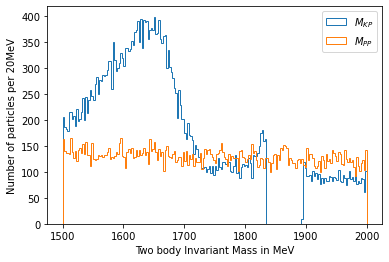

In [6]:
# Two-body Invariant Mass Histogram

fig, ax = plt.subplots(nrows=1, ncols=1)

print('Plotting 1D histogram')
values_m_KP,bins_m_KP,patches_m_KP = ax.hist(m_KP, bins = 200, range = [1500, 2000],histtype='step',label='$M_{KP}$')
ax.hist(m_PP, bins = 200, range = [1500, 2000],histtype='step',label='$M_{PP}$')
ax.set_xlabel('Two body Invariant Mass in MeV')
ax.set_ylabel('Number of particles per 20MeV')
ax.legend()
plt.savefig('m_KP_beforeCutmv.png', dpi = 1000)

Plotting 1D histogram
28982


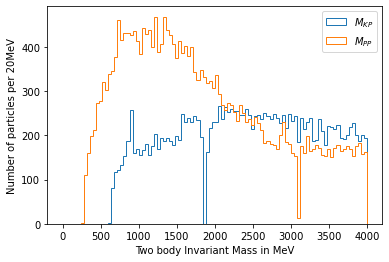

In [7]:
# Two-body Invariant Mass Histogram around peak
lower_cutoff = 5400
upper_cutoff = 5800
KP_main = []
PP_main = []

for i in range(len(m_KPP)):
    if (m_KPP[i] < lower_cutoff) or (m_KPP[i] > upper_cutoff): 
        continue
    KP_main.append(m_KP[i])
    PP_main.append(m_PP[i])

print('Plotting 1D histogram')

fig, ax = plt.subplots(nrows=1, ncols=1)
values_m_KP,bins_m_KP,patches_m_KP = ax.hist(KP_main, bins = 100, range = [0, 4000],histtype='step',label='$M_{KP}$')
ax.hist(PP_main, bins = 100, range = [0, 4000],histtype='step',label='$M_{PP}$')
ax.set_xlabel('Two body Invariant Mass in MeV')
ax.set_ylabel('Number of particles per 20MeV')

ax.legend()
plt.savefig('resonances.png', dpi = 1000)

print('number of events' len(PP_main))

Plotting 1D histogram


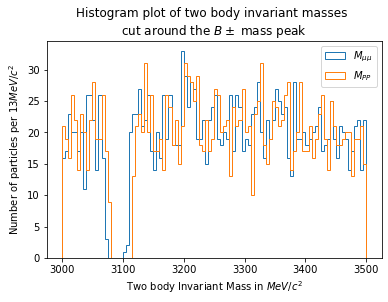

In [8]:
# Muon-muon 2-body invariant mass
fig, ax = plt.subplots(nrows=1, ncols=1)

KP_main = []
PP_main = []
MM_main = []
for i in range(len(m_MM)):
    if (m_KPP[i] < lower_cutoff) or (m_KPP[i] > upper_cutoff): 
        continue
    MM_main.append(m_MM[i])
    PP_main.append(m_PP[i])

print('Plotting 1D histogram')
values_m_KP,bins_m_KP,patches_m_KP = ax.hist(MM_main, bins = 100, range = [3000, 3500],histtype='step',label='$M_{\mu\mu}$')
ax.hist(PP_main, bins = 100, range = [3000, 3500],histtype='step',label='$M_{PP}$')

ax.set_xlabel('Two body Invariant Mass in $MeV/c^2$')
ax.set_ylabel('Number of particles per 13$MeV/c^2$')
ax.legend()
ax.set_title('Histogram plot of two body invariant masses \ncut around the $B\pm$ mass peak')
plt.savefig('m_mu.png', dpi = 1000)

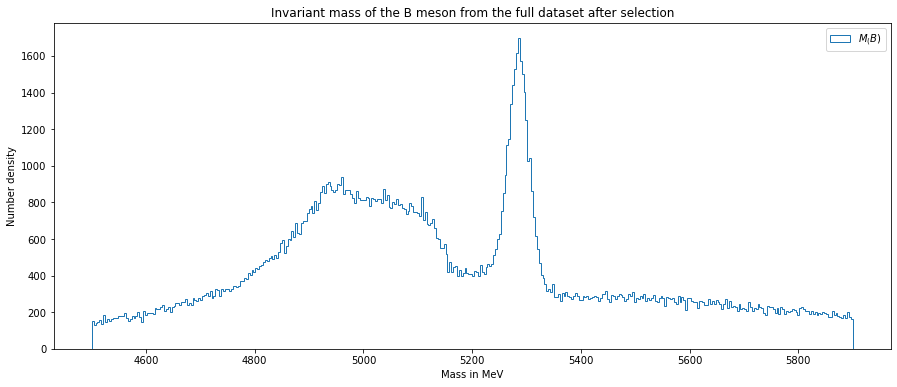

In [9]:
# Invariant Mass of B meson

fig, ax = plt.subplots( figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) 

values_mKPP,bins_mKPP,patches_mKPP = ax.hist(m_KPP, bins = 400, range = [4500,5900],histtype='step',label='$M_(B)$')

ax.set_xlabel('Mass in MeV')
ax.set_ylabel('Number density')
ax.legend()
ax.set_title('Invariant mass of the B meson from the full dataset after selection')
plt.savefig('m_B_beforeCutmv.png', dpi = 1000)

[]

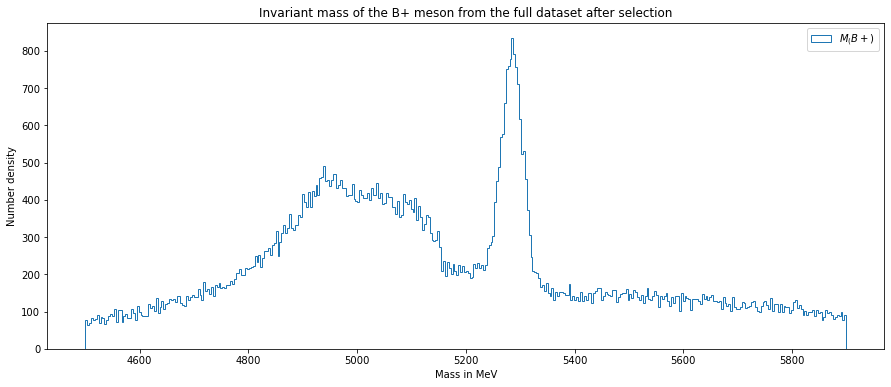

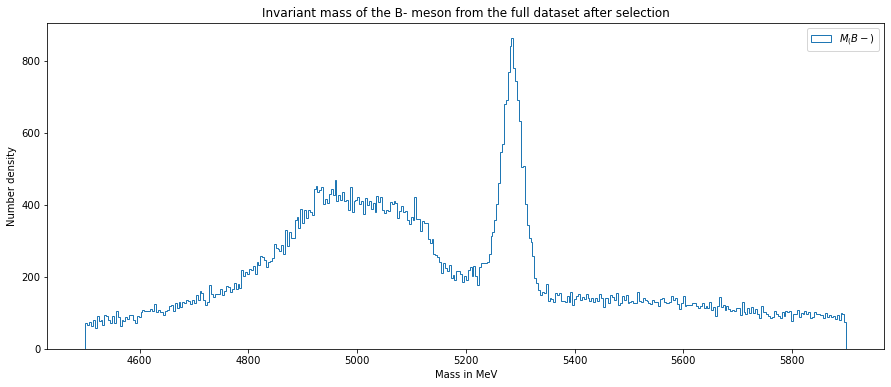

In [10]:
# B+ and B- Invariant Mass histograms

fig, ax = plt.subplots(1, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) 

values_mplus,bins_mplus,patches_mplus = ax.hist(m_Bplus, bins = 400, range = [4500,5900],histtype='step',label='$M_(B+)$')

ax.set_xlabel('Mass in MeV')
ax.set_ylabel('Number density')
ax.legend()
ax.set_title('Invariant mass of the B+ meson from the full dataset after selection')
plt.plot()

fig, ax = plt.subplots(1, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) 

values_mmin,bins_mmin,patches_mmin = ax.hist(m_Bminus, bins = 400, range = [4500,5900],histtype='step',label='$M_(B-)$')

ax.set_xlabel('Mass in MeV')
ax.set_ylabel('Number density')
ax.legend()
ax.set_title('Invariant mass of the B- meson from the full dataset after selection')
plt.savefig('Simulated Invariant mass zoomed.png')
plt.plot()

## 3. Fitting data


Fit for the background by using an exponential decay. 

Fit for the combinatorial background by using a gaussian. 

Fit for the signal by using a crystal ball function - accounts for the loss of energy from going through a magnetic field due to bremsstrahlung radiation.

In [11]:
#exponential decay function
def exponential(x, norm, decay):
    xoffset = 0
    decay = 2000
    return np.array( norm * np.exp(-(x-xoffset)/decay) )

# Gaussian function
def gauss(x, norm, mu, sigma):
    return np.array( (norm / (np.sqrt(2*np.pi)*sigma)) * np.exp( -(x-mu)**2 / 2 / sigma**2 ) )

# Crystal ball function - https://en.wikipedia.org/wiki/Crystal_Ball_function
def crystal(x,norm,mean,sigma):
    
    alpha = 1.5
    n = 1.1
    
    aba = np.abs(np.array(alpha))
    alphasq = np.array(alpha**2)
    nega = -np.array(alpha)

    A = ((n/aba)**n)*(np.exp(-(alphasq/2))) 
    B = (n/aba) - aba
    C = (n/aba)*(1/(n-1))*(np.exp(-(alphasq/2)))
    D = np.sqrt(np.pi/2)*(1+scipy.special.erf(aba/np.sqrt(2)))
    N = 1/((sigma)*(C+D))
    E = ((x-mean)/(sigma))
    
    if (type(E) is float) or (type(E) is np.float64) :
        R = 0
        if E > nega:
            R = (norm*(N)*np.exp(-(E**2)/2))
        elif E <= nega:
            R = (norm*(N)*A*((B-E)**-n) )
    else:
        R= []
        for i in E:
            if i > nega:
                R.append(norm*(N)*np.exp(-(i**2)/2))
            elif i <= nega:
                R.append(norm*(N)*A*((B-i)**(-n)))
    return R 

# fit function combining two individual functions
def fit_function(x, norm4, sigma4, normG, muG, sigmaG, normE, decay):
    return np.array(( gauss(x, norm4, 5100, sigma4) + crystal(x, normG, muG, sigmaG) + exponential(x, normE, decay) ))

def fit_data(bins, values, minX, maxX, p0, boun):
    # determine bin centres
    bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ] # uses simultaneous loop over two arrays
    
    # reduce range to fit only part of curve
    bin_centres_red = [] 
    values_red = []
    for c,v in zip(bin_centres,values):
        if c < minX or c > maxX: 
            continue
        bin_centres_red.append(c)
        values_red.append(v)

    # execute the fit with starting values ~5000,10^4
    coeff_fit,cov_fit = curve_fit(fit_function,bin_centres_red,values_red,p0, maxfev = 20000, 
                                  bounds = boun, sigma = np.sqrt(values_red), absolute_sigma=True) # fit
    fit_vals = [fit_function(x,coeff_fit[0],coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4],coeff_fit[5],coeff_fit[6]) 
                for x in bin_centres_red] 

    chi2parts = np.array( ( np.divide( np.array(values_red) - np.array(fit_vals), np.sqrt( values_red ), 
                                      out = np.array(values_red), where = np.array(values_red) != 0 ) )**2 )
    chi2 = np.sum( chi2parts )
    return coeff_fit, cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)
    
def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covarianve matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2, '/', ndf)
    parcount = 0
    for p, e in zip(coeff,perr):
        parcount += 1
        print('Par {:d} , {}: {:f} +/- {:f}'.format(parcount, coeff_names[parcount-1],p,e))
    
def plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname):
    # plot data as errorbars
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='Data')

    # plot the fit
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4],coeff_fit[5],coeff_fit[6])
    a.plot(x_fit,y_fit,label='Fit',color='r',zorder=10) # zorder makes sure the fit line is on top

    a.legend()
    a.set_xlabel('$m_{inv}(B)$ in $MeV/c^2$')
    a.set_ylabel('Entries per 3.5 $MeV/c^2$')
    plt.savefig(fname, dpi = 1000)

area under crystal curve with norm=1:


(1.000000000308179, 1.227945567450206e-08)

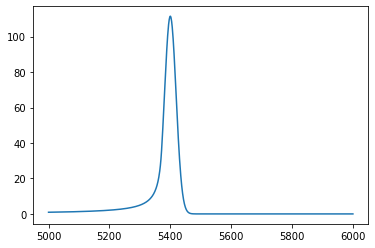

In [12]:
#quick check of the crystal ball function
x  = np.linspace(5000,6000, num = 1000)
plt.plot(x,crystal(x, 10000, 5400, 19))

print("area under crystal curve with norm=1:")
scipy.integrate.quad(crystal, a = -np.inf , b = np.inf, args = (1,5284,19)) # check it is normalised

Fit results with chi2/ndf 155.9789376803856 / 140
Par 1 , norm torix: 35630.132209 +/- 1001.598572
Par 2 , sigma torix: 36.262794 +/- 1.108803
Par 3 , normG: 120544.055894 +/- 1206.901688
Par 4 , peak mass: 5284.411130 +/- 0.216334
Par 5 , B spread: 19.737328 +/- 0.218397
Par 6 , norm exp: 4287.570982 +/- 28.787817
Par 7 , decay: 500.000000 +/- 0.000000
Fit results with chi2/ndf 168.5331610392593 / 140
Par 1 , norm torix: 18016.593247 +/- 716.726255
Par 2 , sigma torix: 36.658717 +/- 1.579715
Par 3 , normG: 60172.080105 +/- 857.717253
Par 4 , peak mass: 5284.303587 +/- 0.309171
Par 5 , B spread: 19.775468 +/- 0.309962
Par 6 , norm exp: 2181.457358 +/- 20.548666
Par 7 , decay: 500.000000 +/- 0.000000
Fit results with chi2/ndf 123.43932529420997 / 140
Par 1 , norm torix: 17447.796703 +/- 695.816788
Par 2 , sigma torix: 35.508477 +/- 1.547670
Par 3 , normG: 60052.853101 +/- 846.456603
Par 4 , peak mass: 5284.512993 +/- 0.302071
Par 5 , B spread: 19.584306 +/- 0.306741
Par 6 , norm exp: 21

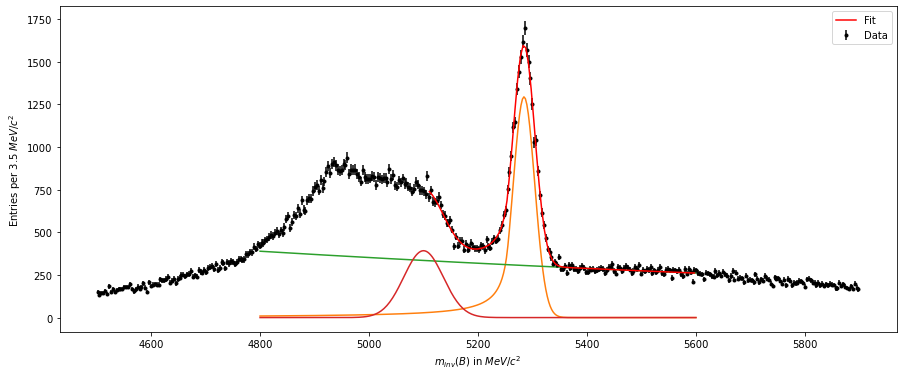

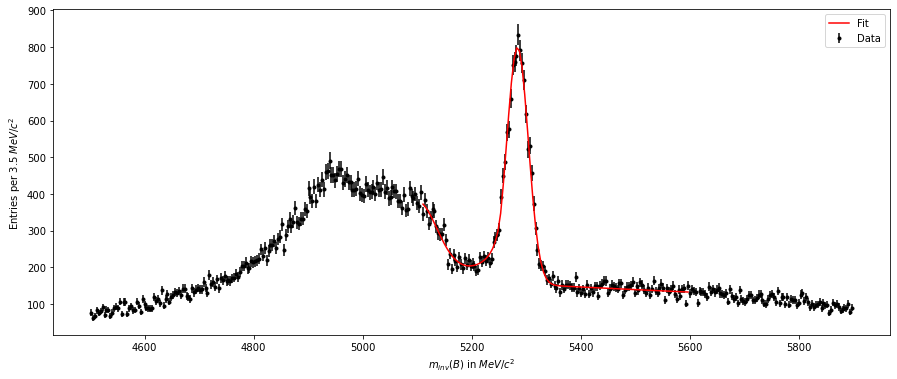

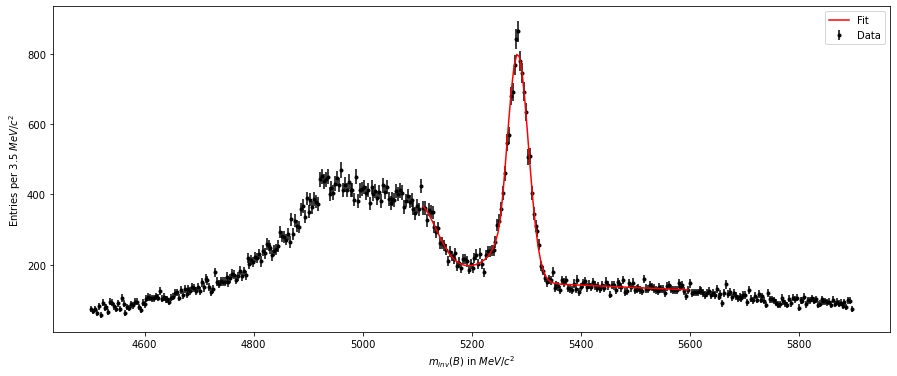

In [13]:
#Start fitting

coeff_names = ['norm torix', 'sigma torix', 'normG', 'peak mass', 'B spread', 'norm exp', 'decay','alphaG', 'nuG', 'xoffset']
fit_bounds = ([0, 0, 40000, 5250, 18, 0, 0.1], [np.inf,np.inf,180000, 5300, 22,np.inf, np.inf])
start_val = [15000,30,(33000*3.5),5285,20,400,500]
start_val_pm =[15000,30,(15574*3.5),5285,20,400,500]

coeff_Kpipi_fit,cov_Kpipi_fit, bin_centres_KPP, bin_centres_red_KPP, chi2_KPP, ndf_KPP \
    = fit_data( bins_mKPP, values_mKPP, minX=5110, maxX=5600, p0=start_val, boun=fit_bounds )

coeff_mplus_fit,cov_mplus_fit, bin_centres_mplus, bin_centres_red_mplus, chi2_mplus, ndf_mplus \
    = fit_data( bins_mplus, values_mplus, minX=5110, maxX=5600, p0=start_val_pm, boun=fit_bounds )

coeff_mmin_fit,cov_mmin_fit, bin_centres_mmin, bin_centres_red_mmin, chi2_mmin, ndf_mmin \
    = fit_data( bins_mmin, values_mmin, minX=5110, maxX=5600, p0=start_val_pm, boun=fit_bounds )


print_results(coeff_Kpipi_fit,cov_Kpipi_fit, chi2_KPP, ndf_KPP)
mean = coeff_Kpipi_fit[3]
spread = coeff_Kpipi_fit[4]
decay = coeff_Kpipi_fit[6]

lower_cutoff = mean - 4 * spread
upper_cutoff = mean + 4 * spread

print_results(coeff_mplus_fit,cov_mplus_fit, chi2_mplus, ndf_mplus)
print_results(coeff_mmin_fit,cov_mmin_fit, chi2_mmin, ndf_mmin)


norm_plus = coeff_mplus_fit[2]
norm_min = coeff_mmin_fit[2]

# plot results
fig, ax = plt.subplots( figsize=(15, 6))
plot_results(ax,bin_centres_KPP,bin_centres_red_KPP,values_mKPP,coeff_Kpipi_fit,'fit.svg')
coeff_fit = coeff_Kpipi_fit

x_fit = np.linspace(4800,5600,300)
#coeff_names = ['norm torix', 'sigma torix', 'normG', 'peak mass', 'B spread', 'norm exp', 'decay','alphaG', 'nuG', 'xoffset']
yfit1 = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4],coeff_fit[5],coeff_fit[6])
#gauss 
yfit2 = fit_function(x_fit,0,coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4],0,coeff_fit[6])
#exponential 
yfit3 = fit_function(x_fit,0,coeff_fit[1],0,coeff_fit[3],coeff_fit[4],coeff_fit[5],coeff_fit[6])
#combinatorix 
yfit4 = fit_function(x_fit,coeff_fit[0],coeff_fit[1],0,coeff_fit[3],coeff_fit[4],0,coeff_fit[6])
#ax.plot(x_fit, yfit1)
ax.plot(x_fit, yfit2)
ax.plot(x_fit, yfit3)
ax.plot(x_fit, yfit4)
plt.savefig('fit.png', dpi = 1200)
plt.plot()

fig, ax = plt.subplots( figsize=(15, 6))
plot_results(ax,bin_centres_mplus,bin_centres_red_mplus,values_mplus,coeff_mplus_fit,'fitp.png')

fig, ax = plt.subplots( figsize=(15, 6))
plot_results(ax,bin_centres_mmin,bin_centres_red_mmin,values_mmin,coeff_mmin_fit,'fitm.png')

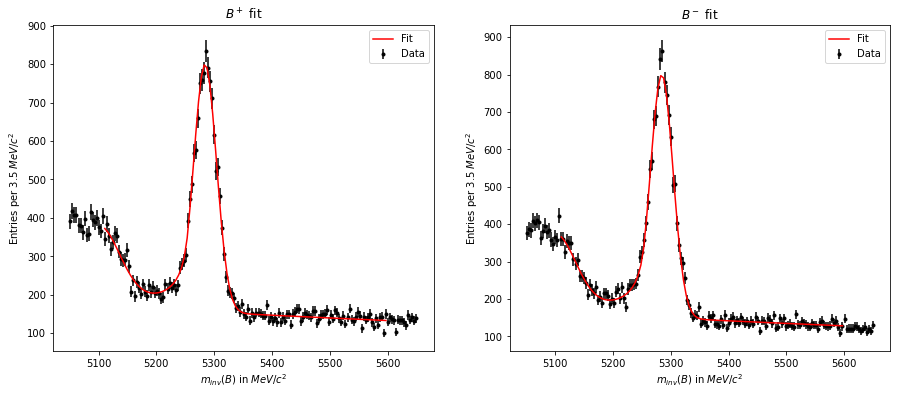

In [14]:
plotcentres_mplus = []
plotvals_mplus = []
plotcentres_mmin = []
plotvals_mmin = []

minrange = 5050
maxrange = 5650

for i in range(len(bin_centres_mplus)):
    if bin_centres_mplus[i] > minrange and bin_centres_mplus[i] < maxrange :
        plotcentres_mplus.append(bin_centres_mplus[i])
        plotvals_mplus.append(values_mplus[i])
        
for i in range(len(bin_centres_mmin)):
    if bin_centres_mmin[i] > minrange and bin_centres_mmin[i] < maxrange :
        plotcentres_mmin.append(bin_centres_mmin[i])
        plotvals_mmin.append(values_mmin[i])
        
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))

plot_results(ax[0],plotcentres_mplus,bin_centres_red_mplus,plotvals_mplus,coeff_mplus_fit,'fitp.png')
ax[0].set_title("$B^+$ fit")
ax[1].set_title("$B^-$ fit")

plot_results(ax[1],plotcentres_mmin,bin_centres_red_mmin,plotvals_mmin,coeff_mmin_fit,'fitm.png')

### 3.1 Calculating the asymmetry by finding the relative areas under the theoretical gaussian as defined by the fit


In [15]:
up = mean + spread * 4
down = mean - spread * 4
lower = 5400
upper = 5800

I1 = (np.exp(up/decay) - np.exp(down/decay))
I2 = (np.exp(upper/decay) - np.exp(lower/decay))
signal_strength = I1/I2

print("signal strength :",signal_strength)

signal strength : 0.205345145912391


In [16]:
Asym = (norm_min - norm_plus)/(norm_min+norm_plus)
dAsym = np.sqrt((1-A**2)/(norm_min+norm_plus))
print('asymmetry : {}'.format(Asym))
print('Uncertainty : {}'.format(dAsym))

asymmetry : -0.0009916994830163907
Uncertainty : 0.002883563820503123


### 3.2 Calculating the asymmetry by finding the number of events that took place within 4 sigma of the gaussian peak 


In [17]:
pluscount = 0
mincount  = 0

for i in range(len(m_KPP)):
    if np.abs(m_KPP[i]-mean) < (4*spread):
        if Bc[i] == 1:
            pluscount += 1
        elif Bc[i] == -1:
            mincount += 1
        
print('pluscount : {}'.format(pluscount))
print('mincount : {}'.format(mincount))

Asym = (mincount - pluscount)/(mincount+pluscount)
dAsym = np.sqrt((1-A**2)/(mincount+pluscount))
print('asymmetry : {}'.format(A))
print('Uncertainty : {}'.format(dA))

pluscount : 16765
mincount : 16567
asymmetry : -0.018353664065541942
Uncertainty : 0.00230911675738727


## 4. Dalitz Plots

[]

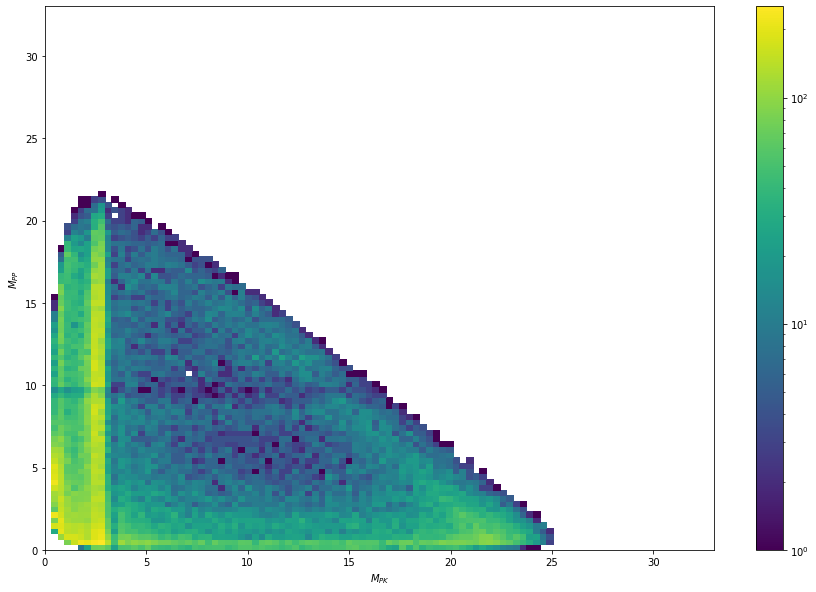

In [18]:
# background from the combinatorics (change cutoffs to variables)
KPsq = (np.array(m_KP))**2
PPsq = (np.array(m_PP))**2
KP_background2 = []
PP_background2 = []

for i in range(len(m_KPP)):
    if (m_KPP[i] < 4800) or (m_KPP[i] > 5150): 
        continue
    KP_background2.append(KPsq[i])
    PP_background2.append(PPsq[i])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# change units into GeV^2
h2d = ax.hist2d( np.divide(KP_background2,10**6), np.divide(PP_background2,10**6), bins = [100,100], 
                range = [[0,33],[0,33]],norm=colors.LogNorm())
ax.set_xlabel('$M_{PK}$')
ax.set_ylabel('$M_{PP}$')
fig.colorbar(h2d[3],ax=ax) # colour scale
plt.savefig('pXpY.png', dpi=1000)
plt.plot()

33332


[]

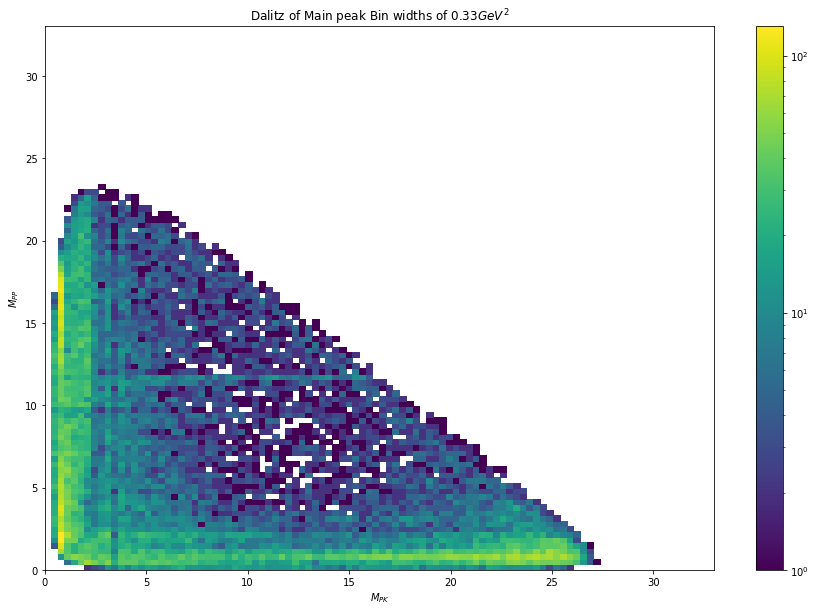

In [19]:
#main peak

lower_cutoff = mean - 4*spread
upper_cutoff = mean + 4*spread
KP_main = []
PP_main = []

for i in range(len(m_KPP)):
    if (m_KPP[i] < lower_cutoff) or (m_KPP[i] > upper_cutoff): 
        continue
    KP_main.append(KPsq[i])
    PP_main.append(PPsq[i])
print('number of events :',len(KP_main))


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

h2d = ax.hist2d( np.divide(KP_main,10**6), np.divide(PP_main,10**6), bins = [100,100], 
                range = [[0,33],[0,33]],norm=colors.LogNorm())
ax.set_xlabel('$M_{PK}$')
ax.set_ylabel('$M_{PP}$')
ax.set_title('Dalitz of Main peak Bin widths of $0.33GeV^2$')
fig.colorbar(h2d[3],ax=ax) # colour scale
plt.savefig('pxpy.png', dpi=1000)
plt.plot()

[]

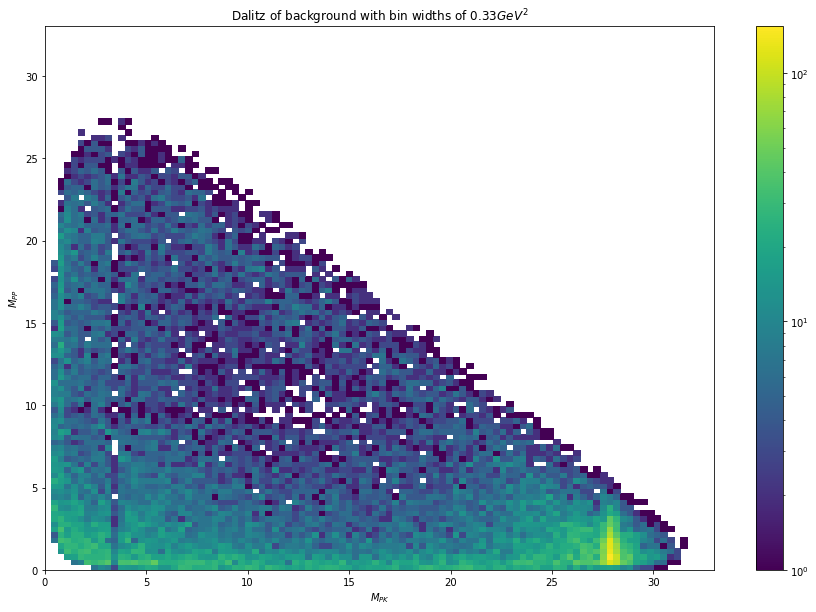

In [20]:
#Background from exponential

KPsq = (np.array(m_KP))**2
PPsq = (np.array(m_PP))**2

KP_background = []
PP_background = []

for i in range(len(m_KPP)):
    if (m_KPP[i] < lower) or (m_KPP[i] > upper): 
        continue
    KP_background.append(KPsq[i])
    PP_background.append(PPsq[i])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

h2d = ax.hist2d( np.divide(KP_background,10**6), np.divide(PP_background,10**6), bins = [100,100], 
                range = [[0,33],[0,33]],norm=colors.LogNorm())

ax.set_xlabel('$M_{PK}$')
ax.set_ylabel('$M_{PP}$')
ax.set_title('Dalitz of background with bin widths of $0.33GeV^2$')

fig.colorbar(h2d[3],ax=ax) # colour scale
plt.savefig('background.png', dpi=1000)
plt.plot()

Aysmmetry for the background is larger as it goes well above the 3 body invariant mass of the main peak.

### 4.1 Variable Bin Widths

Implement variable bin witdths and subtract backgrounds events from the data

In [21]:
#variable bins
#TBA iterate through many configurations to maximise local asymmetries
def bins(nbins, arrayx, arrayy):
    xbinwidth = [0]
    ybinwidth = [0]
    xbinlocation = []
    ybinlocation = []
    
    kps = np.sort(arrayx)
    pps = np.sort(arrayy)
    xstep = np.int_(np.floor(len(kps)/nbins))
    ystep = np.int_(np.floor(len(pps)/nbins))
    
    for i in range(0,len(kps),xstep):
        xbinlocation.append(i)
    for i in range(0,len(pps),ystep):
        ybinlocation.append(i)

    for i in xbinlocation:

        xedges = (kps[i] + kps[i+1])/2

        xbinwidth.append(xedges)
        
    for i in range(0,5):
        xbinwidth.append(kps[-1]+(i*2000000))

    for i in ybinlocation:

        yedges = (pps[i] + pps[i+1])/2

        ybinwidth.append(yedges)
    
    for i in range(0,5):
        ybinwidth.append(pps[-1]+(i*2000000))

    xbinwidth = np.array(np.divide(xbinwidth,10**6))
    ybinwidth = np.array(np.divide(ybinwidth,10**6))

    return xbinwidth, ybinwidth

In [22]:
lower_cutoff = mean - 4*spread
upper_cutoff = mean + 4*spread
KP_main = []
PP_main = []
weights1 = []
weights2 = []


KPsq = (np.array(m_KP))**2
PPsq = (np.array(m_PP))**2

KP_background = []
PP_background = []

for i in range(len(m_KPP)):
    if (m_KPP[i] < lower) or (m_KPP[i] > upper): 
        continue
    KP_background.append(KPsq[i])
    PP_background.append(PPsq[i])

for i in range(len(m_KPP)):
    if (m_KPP[i] < lower_cutoff) or (m_KPP[i] > upper_cutoff): 
        continue
    KP_main.append(KPsq[i])
    PP_main.append(PPsq[i])
    
binsx, binsy = bins(15, KP_main, PP_main)

[]

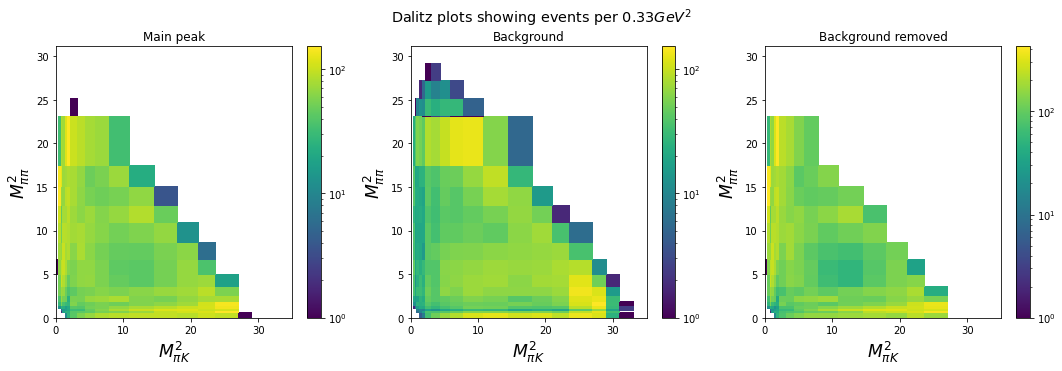

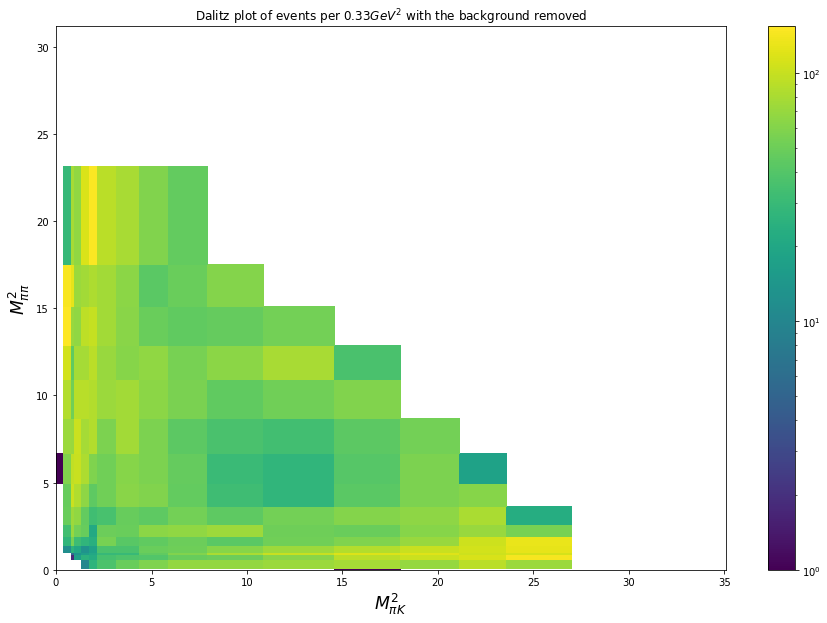

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.2) # increase horizontal space between plots

h2d0 = ax[0].hist2d( np.divide(KP_main,10**6), np.divide(PP_main,10**6), bins = [binsx,binsy], 
                    range = [[0,33],[0,33]],norm=colors.LogNorm())
ax[0].set_xlabel('$M_{\pi K}^2$', size = 'xx-large')
ax[0].set_ylabel('$M_{\pi \pi}^2$', size = 'xx-large')
fig.colorbar(h2d[3],ax=ax[0]) # colour scale

h2d1 = ax[1].hist2d( np.divide(KP_background,10**6), np.divide(PP_background,10**6), bins = [binsx,binsy], 
                    range = [[0,33],[0,33]],norm=colors.LogNorm())
ax[1].set_xlabel('$M_{\pi K}^2$', size = 'xx-large')
ax[1].set_ylabel('$M_{\pi \pi}^2$', size = 'xx-large')
fig.colorbar(h2d[3],ax=ax[1]) # colour scale

xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

w1 = (np.array(h2d0[0])).flatten()
w2 = (np.array(h2d1[0])).flatten()
w2 = w2*signal_strength
wsub = np.subtract(w1,w2)
wsub2 = wsub

#removing negative values and forcing the scale on the right to match up by setting 
for i in range(len(wsub)):
    if wsub[i] < 0:
        wsub2[i] = 0
    if (wsub[i] > 0) and (wsub[i] < 1):
        wsub2[i] =1
        
h2d2 = ax[2].hist2d(xcentres,ycentres,weights=wsub2, bins = [h2d1[1],h2d1[2]],norm=colors.LogNorm()) 
fig.colorbar(h2d2[3],ax=ax[2]) # colour scale 
ax[2].set_xlabel('$M_{\pi K}^2$', size = 'xx-large')
ax[2].set_ylabel('$M_{\pi \pi}^2$', size = 'xx-large')


ax[0].set_title('Main peak')
ax[1].set_title('Background')
ax[2].set_title('Background removed')
plt.suptitle('Dalitz plots showing events per $0.33GeV^2$ \n ',y=.99, size = 'x-large')
plt.savefig('All three.svg', dpi = 1200)
plt.plot()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
fig.subplots_adjust(wspace=0.3) 

# recycle the binning from above
ax.hist2d(xcentres,ycentres,weights=wsub2, bins = [h2d1[1],h2d1[2]],norm=colors.LogNorm()) 
plt.plot()

ax.set_xlabel('$M_{\pi K}^2$', size = 'xx-large')
ax.set_ylabel('$M_{\pi \pi}^2$', size = 'xx-large')
ax.set_title('Dalitz plot of events per $0.33GeV^2$ with the background removed')
fig.colorbar(h2d[3],ax=ax) # colour scale
plt.savefig('Removed.svg', dpi=1000)
plt.plot()


### 4.2 Asymmetry Dalitz plots

Calculate the asymmetry for each bin

In [24]:
lower_cutoff = mean - 4 * spread
upper_cutoff = mean + 4 * spread

KP_plus = []
PP_plus = [] 
KP_minus = []
PP_minus = []
m_KPP_plus = []
m_KPP_minus = []

KP_main_plus = []
PP_main_plus = []
KP_main_minus = []
PP_main_minus = []

KP_background_plus = []
PP_background_plus = []
KP_background_minus = []
PP_background_minus = []

weights1 = []
weights2 = []

for i in range(len(Bcc)):
    if (Bcc[i] == 1): 
        KP_plus.append(KPsq[i])
        PP_plus.append(PPsq[i])
        m_KPP_plus.append(m_KPP[i])
    if (Bcc[i] == -1):
        KP_minus.append(KPsq[i])
        PP_minus.append(PPsq[i])
        m_KPP_minus.append(m_KPP[i])



for i in range(len(m_KPP_plus)):
    if (m_KPP_plus[i] < lower_cutoff) or (m_KPP_plus[i] > upper_cutoff): 
        continue
    KP_main_plus.append(KP_plus[i])
    PP_main_plus.append(PP_plus[i])
    
for i in range(len(m_KPP_minus)):
    if (m_KPP_minus[i] < lower_cutoff) or (m_KPP_minus[i] > upper_cutoff): 
        continue
    KP_main_minus.append(KP_minus[i])
    PP_main_minus.append(PP_minus[i])
    
KP_background_plus = []
PP_background_plus = []
KP_background_minus = []
PP_background_minus = []


I1 = -(np.exp(upper_cutoff/decay) - np.exp(lower_cutoff/decay))
I2 = -(np.exp(upper/decay) - np.exp(lower/decay))
signal_strength = I1/I2

for i in range(len(m_KPP_plus)):
    if (m_KPP_plus[i] < lower) or (m_KPP_plus[i] > upper): 
        continue
    KP_background_plus.append(KPsq[i])
    PP_background_plus.append(PPsq[i])
               
for i in range(len(m_KPP_minus)):
    if (m_KPP_minus[i] < lower) or (m_KPP_minus[i] > upper): 
        continue
    KP_background_minus.append(KPsq[i])
    PP_background_minus.append(PPsq[i])


<Figure size 432x288 with 0 Axes>

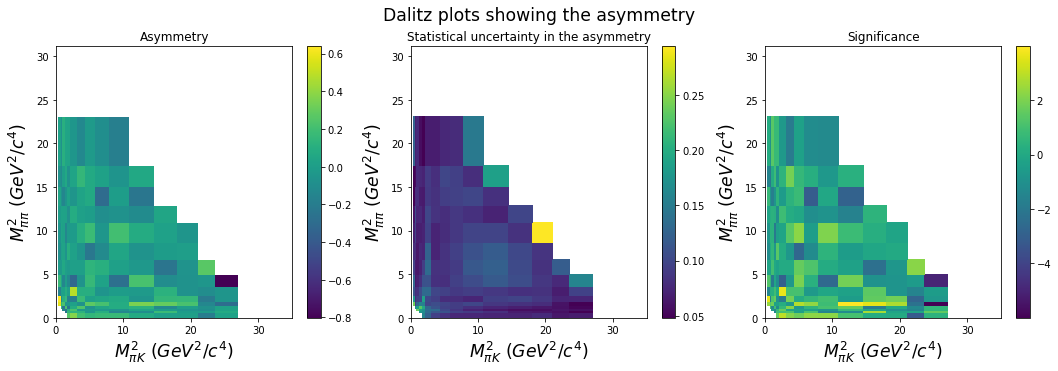

In [25]:
# easier to make a histogram and read out the values than cutting out the data for each bin

h2d0_plus = plt.hist2d( np.divide(KP_main_plus,10**6), np.divide(PP_main_plus,10**6), bins = [binsx,binsy], 
                       range = [[0,33],[0,33]],norm=colors.LogNorm())
h2d0_minus = plt.hist2d( np.divide(KP_main_minus,10**6), np.divide(PP_main_minus,10**6), bins = [binsx,binsy], 
                        range = [[0,33],[0,33]],norm=colors.LogNorm())

h2d1_plus = plt.hist2d( np.divide(KP_background_plus,10**6), np.divide(PP_background_plus,10**6), 
                       bins = [binsx,binsy], range = [[0,33],[0,33]],norm=colors.LogNorm())
h2d1_minus = plt.hist2d( np.divide(KP_background_minus,10**6), np.divide(PP_background_minus,10**6), 
                        bins = [binsx,binsy], range = [[0,33],[0,33]],norm=colors.LogNorm())

xcentres_plus = []
ycentres_plus = []
for a,b in zip(h2d1_plus[1][0:-1],h2d1_plus[1][1:]):
    for c,d in zip(h2d1_plus[2][0:-1],h2d1_plus[2][1:]):
        xcentres_plus.append( (a+b)/2 )
        ycentres_plus.append( (c+d)/2 )
               
xcentres_minus = []
ycentres_minus = []
for a,b in zip(h2d1_minus[1][0:-1],h2d1_minus[1][1:]):
    for c,d in zip(h2d1_minus[2][0:-1],h2d1_minus[2][1:]):
        xcentres_minus.append( (a+b)/2 )
        ycentres_minus.append( (c+d)/2 )               
               
w1_plus = (np.array(h2d0_plus[0])).flatten()
w2_plus = (np.array(h2d1_plus[0])).flatten()
w2_plus = w2_plus*signal_strength
wsub_plus = np.subtract(w1_plus,w2_plus)
wsub2_plus = wsub_plus              
w1_minus = (np.array(h2d0_minus[0])).flatten()
w2_minus = (np.array(h2d1_minus[0])).flatten()
w2_minus = w2_minus*signal_strength
wsub_minus = np.subtract(w1_minus,w2_minus)
wsub2_minus = wsub_minus
wsub = np.zeros(len(wsub_minus))

for i in range(len(wsub_minus)):
    if (wsub_minus[i]> 0.5) and (wsub_plus[i] > 0.5):     
        wsub[i] = (wsub_minus[i] - wsub_plus[i]) / (wsub_minus[i] + wsub_plus[i])
    else: wsub[i] = np.nan

wsub2 = wsub
wsub_error = np.zeros(len(wsub_minus))

for i in range(len(wsub_minus)):    
    if (wsub_minus[i] > 0.5) and (wsub_plus[i] > 0.5):
        wsub_error[i] = np.sqrt(np.abs((1-(wsub[i]**2))/(wsub_minus[i] + wsub_plus[i])))
        
    else: wsub_error[i] = np.nan

wsub_sig = np.zeros(len(wsub_minus))        
for i in range(len(wsub_minus)):
    if wsub[i] == 0:
        wsub_sig[i] = (-0.1/wsub_error[i])
        
    else:
        wsub_sig[i] = (wsub[i]/wsub_error[i])

plt.clf()          
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.2) # increase horizontal space between plots

cmap1 = copy.copy(colormap.get_cmap("viridis")) #viridis #cividis #brg #plasma
cmap1.set_bad('white')

# recycle the binning from above
h2d2_asymmetry = ax[0].hist2d(xcentres_plus,ycentres_plus,weights=wsub2, 
                              bins = [h2d1_plus[1],h2d1_plus[2]], cmap = cmap1) 

h2d2_error = ax[1].hist2d(xcentres_plus,ycentres_plus,weights=wsub_error, cmin = 0.001 , 
                          bins = [h2d1_plus[1],h2d1_plus[2]],cmap = 'viridis') 

h2d2_sig = ax[2].hist2d(xcentres_plus,ycentres_plus,weights=(wsub/wsub_error) , 
                        bins = [h2d1_plus[1],h2d1_plus[2]]) 


ax[0].set_title('Asymmetry')
ax[1].set_title('Statistical uncertainty in the asymmetry')
ax[2].set_title('Significance')
plt.suptitle('Dalitz plots showing the asymmetry \n ',y=.99, size = 'xx-large')

fig.colorbar(h2d2_asymmetry[3],ax=ax[0]) # colour scale 
fig.colorbar(h2d2_error[3],ax=ax[1]) # colour scale 
fig.colorbar(h2d2_sig[3],ax=ax[2])

ax[0].set_xlabel('$M_{\pi K}^2$ ($GeV^2/c^4$)', size = 'xx-large')
ax[0].set_ylabel('$M_{\pi \pi}^2$ ($GeV^2/c^4$)', size = 'xx-large')
ax[1].set_xlabel('$M_{\pi K}^2$ ($GeV^2/c^4$)', size = 'xx-large')
ax[1].set_ylabel('$M_{\pi \pi}^2$ ($GeV^2/c^4$)', size = 'xx-large')
ax[2].set_xlabel('$M_{\pi K}^2$ ($GeV^2/c^4$)', size = 'xx-large')
ax[2].set_ylabel('$M_{\pi \pi}^2$ ($GeV^2/c^4$)', size = 'xx-large')

#exes = np.linspace(0, 100, 300)
#ya = []
#for i in exes:
#    ya.append(24)
#yplot = 24*np.cos((exes-4)/16)
#yplot2 = ((-1)/(exes)) +24
#ax[0].plot(exes, (28.7-exes))
#ax[2].plot(1.98, 15.18, 'ro')

plt.savefig('cuttting white.svg', dpi = 1200)


In [26]:
print(np.count_nonzero(wsub_sig != np.nan))

441


In [27]:
# find bins with high significance

for i in range(len(wsub_error)):
    tolerance = 4 
    if np.abs(wsub[i]) > tolerance*wsub_error[i] :
        print(wsub[i])
        print(wsub_error[i])
        print(wsub[i]/wsub_error[i], "\n")

-0.2894419490878149
0.048324101053719586
-5.98959820827409 

-0.8021270770579042
0.160152295812602
-5.0085268711757465 



[1, 1.0, 1.0, 1, 1, 1, 1.4142135623730951, 2.23606797749979, 1.7320508075688772, 3.0, 4.123105625617661, 5.196152422706632, 5.291502622129181, 5.5677643628300215, 5.0, 3.7416573867739413, 3.7416573867739413, 3.0, 2.0, 1, 2.0, 1, 1, 1, 1, 1]


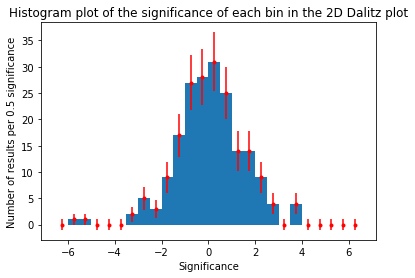

In [28]:
sig = wsub/wsub_error
fig, ax = plt.subplots(nrows=1, ncols=1)
sig_array, sig_bins, patches = ax.hist(sig,bins = 26, range = [-6.5,6.5], histtype = 'stepfilled')
sig_centres = []
for i,j in zip(sig_bins[0:-1],sig_bins[1:]):
        sig_centres.append( (i+j)/2 )
        
        
yerrr = []

for i in range(len(sig_centres)):
    if sig_array[i] == 0: 
        yerrr.append(1)
    else: yerrr.append( np.sqrt(sig_array[i]))
        
print(yerrr)

ax.set_xlabel('Significance')
ax.set_ylabel('Number of results per 0.5 significance')
ax.set_title('Histogram plot of the significance of each bin in the 2D Dalitz plot')
plt.errorbar(sig_centres,sig_array, yerr = yerrr, fmt = 'r.')
plt.savefig('m_mu.png', dpi = 1000)

list of errors: 
 [1.         1.         1.41421356 2.23606798 1.73205081 3.
 4.12310563 5.19615242 5.29150262 5.56776436 5.         3.74165739
 3.74165739 3.         2.         2.        ]
lift of coefficients (norm, mean, spread): 
 [92.07213357  0.13001605  1.3064807 ]


<ErrorbarContainer object of 3 artists>

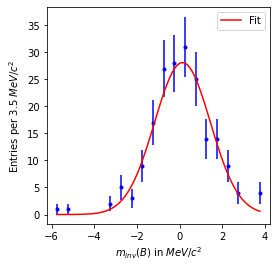

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))

var = [100,0,1]
indices = []

for i in range(len(sig_centres)):
    if sig_array[i] == 0: 
        indices.append(i)
sig_array   = np.delete(sig_array, indices)
sig_centres = np.delete(sig_centres, indices)        
              
yerrr =  np.sqrt(sig_array)
print("list of errors: \n", yerrr)
    
coeff,cov = curve_fit(gauss, sig_centres, sig_array, p0 = var, maxfev = 2000, sigma = yerrr, absolute_sigma = True)
print("lift of coefficients (norm, mean, spread): \n", coeff)

x_fit = np.linspace(sig_centres[0],sig_centres[-1],100)
y_fit = gauss(x_fit,coeff[0],coeff[1],coeff[2])
ax.plot(x_fit,y_fit,label='Fit',color='r',zorder=10) # zorder makes sure the fit line is on top

ax.legend()
ax.set_xlabel('$m_{inv}(B)$ in $MeV/c^2$')
ax.set_ylabel('Entries per 3.5 $MeV/c^2$')
plt.savefig('gaussfit.svg', dpi = 1200)
plt.errorbar(sig_centres,sig_array, yerr = yerrr, fmt = 'b.')